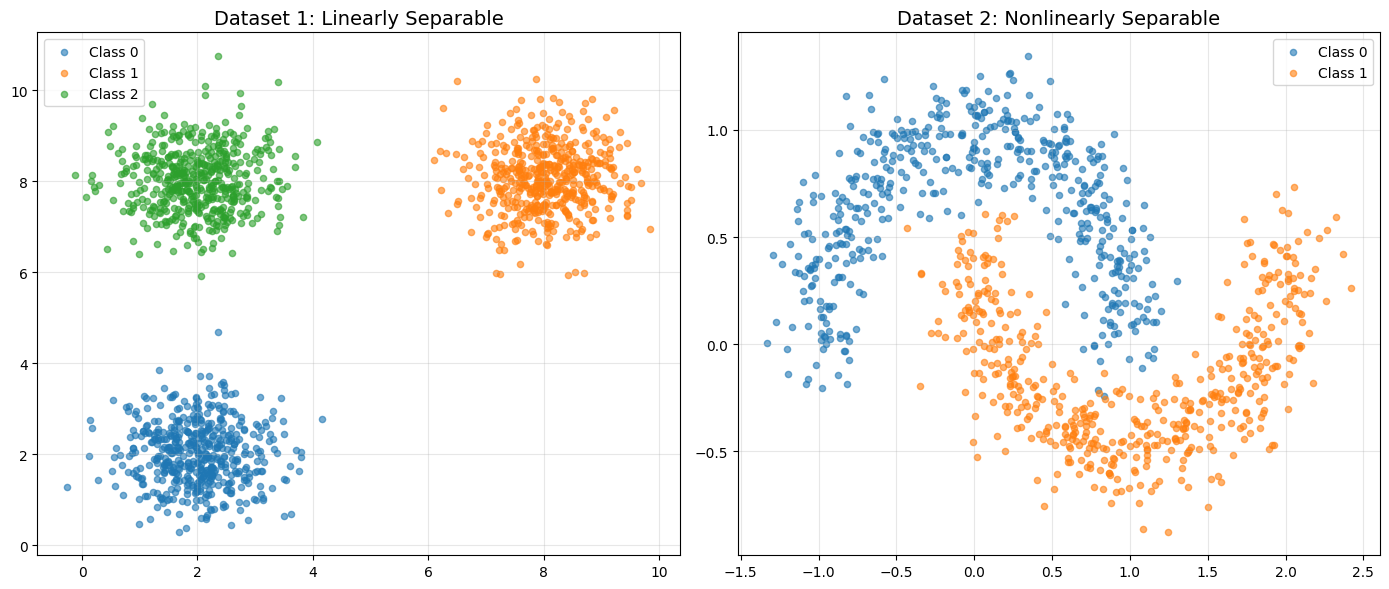

✓ Datasets generated successfully!
  - dataset1.txt: 3 classes, linearly separable
  - dataset2.txt: 2 classes, nonlinearly separable


In [ ]:
from sklearn.datasets import make_blobs, make_moons
import numpy as np
import matplotlib.pyplot as plt

# DATASET 1: Linearly Separable
X1, y1 = make_blobs(
    n_samples=[500, 500, 500],
    n_features=2,
    centers=[[2, 2], [8, 8], [2, 8]],
    cluster_std=0.7,
    random_state=42
)

# Save Dataset 1
data1 = np.column_stack([X1, y1])
np.savetxt('dataset1.txt', data1,
           header='500 500 500',
           comments='',
           fmt='%.6f %.6f %d')

# DATASET 2: Nonlinearly Separable
X2, y2 = make_moons(n_samples=1000, noise=0.15, random_state=42)

# Balance to 500 each
idx0 = np.where(y2 == 0)[0][:500]
idx1 = np.where(y2 == 1)[0][:500]
X2 = X2[np.concatenate([idx0, idx1])]
y2 = y2[np.concatenate([idx0, idx1])]

# Save Dataset 2
data2 = np.column_stack([X2, y2])
np.savetxt('dataset2.txt', data2,
           header='500 500',
           comments='',
           fmt='%.6f %.6f %d')

# Visualize both
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot Dataset 1
for class_id in [0, 1, 2]:
    mask = y1 == class_id
    ax1.scatter(X1[mask, 0], X1[mask, 1],
               label=f'Class {class_id}', s=20, alpha=0.6)
ax1.set_title('Dataset 1: Linearly Separable', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot Dataset 2
for class_id in [0, 1]:
    mask = y2 == class_id
    ax2.scatter(X2[mask, 0], X2[mask, 1],
               label=f'Class {class_id}', s=20, alpha=0.6)
ax2.set_title('Dataset 2: Nonlinearly Separable', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('datasets_preview.png', dpi=150)
plt.show()

print("✓ Datasets generated successfully!")
print("  - dataset1.txt: 3 classes, linearly separable")
print("  - dataset2.txt: 2 classes, nonlinearly separable")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

class FCNN:
    def __init__(self, input_dim, hidden_dims, output_dim, learning_rate=0.01):
        """
        input_dim: Number of input features (2 for your datasets)
        hidden_dims: List of hidden layer sizes [e.g., [10] or [15, 10]]
        output_dim: Number of output classes
        learning_rate: Learning rate for SGD
        """
        self.learning_rate = learning_rate
        self.layers = []

        # Initialize weights and biases for each layer
        layer_dims = [input_dim] + hidden_dims + [output_dim]

        for i in range(len(layer_dims) - 1):
            # Xavier initialization for better convergence
            weight = np.random.randn(layer_dims[i+1], layer_dims[i]) * np.sqrt(2.0 / layer_dims[i])
            bias = np.zeros((layer_dims[i+1], 1))
            self.layers.append({'W': weight, 'b': bias})

    def sigmoid(self, z):
        """Sigmoid activation function"""
        return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

    def sigmoid_derivative(self, a):
        """Derivative of sigmoid"""
        return a * (1 - a)

    def softmax(self, z):
        """Softmax for output layer"""
        exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
        return exp_z / np.sum(exp_z, axis=0, keepdims=True)

    def forward_propagation(self, X):
        """
        Forward pass through network
        Returns: activations of all layers
        """
        activations = [X]

        for i, layer in enumerate(self.layers):
            z = layer['W'] @ activations[-1] + layer['b']

            if i == len(self.layers) - 1:  # Output layer
                a = self.softmax(z)
            else:  # Hidden layers
                a = self.sigmoid(z)

            activations.append(a)
            layer['z'] = z  # Store for backprop

        return activations

    def compute_loss(self, y_pred, y_true):
        """
        Squared error loss for one sample
        y_true: one-hot encoded
        """
        return 0.5 * np.sum((y_pred - y_true) ** 2)

    def backward_propagation(self, activations, y_true):
        """
        Backpropagation using SGD
        Returns: gradients for weights and biases
        """
        gradients = []
        m = y_true.shape[1]  # batch size (1 for SGD)

        # Output layer error (using squared error)
        delta = (activations[-1] - y_true)

        # Backpropagate through layers
        for i in reversed(range(len(self.layers))):
            # Compute gradients
            dW = delta @ activations[i].T / m
            db = np.sum(delta, axis=1, keepdims=True) / m

            gradients.insert(0, {'dW': dW, 'db': db})

            # Propagate error to previous layer
            if i > 0:
                delta = (self.layers[i]['W'].T @ delta) * self.sigmoid_derivative(activations[i])

        return gradients

    def update_parameters(self, gradients):
        """Update weights using SGD"""
        for i, layer in enumerate(self.layers):
            layer['W'] -= self.learning_rate * gradients[i]['dW']
            layer['b'] -= self.learning_rate * gradients[i]['db']

    def train(self, X_train, y_train, X_val, y_val, epochs=1000):
        """
        Train using Stochastic Gradient Descent
        Returns: training history
        """
        train_losses = []
        val_losses = []

        for epoch in range(epochs):
            epoch_loss = 0

            # SGD: Loop through each training example
            for i in range(X_train.shape[1]):
                X_sample = X_train[:, i:i+1]
                y_sample = y_train[:, i:i+1]

                # Forward pass
                activations = self.forward_propagation(X_sample)

                # Compute loss
                loss = self.compute_loss(activations[-1], y_sample)
                epoch_loss += loss

                # Backward pass
                gradients = self.backward_propagation(activations, y_sample)

                # Update parameters
                self.update_parameters(gradients)

            # Average training loss
            avg_train_loss = epoch_loss / X_train.shape[1]
            train_losses.append(avg_train_loss)

            # Validation loss
            val_activations = self.forward_propagation(X_val)
            val_loss = np.mean([self.compute_loss(val_activations[-1][:, i:i+1], y_val[:, i:i+1])
                               for i in range(X_val.shape[1])])
            val_losses.append(val_loss)

            if (epoch + 1) % 100 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")

        return train_losses, val_losses

    def predict(self, X):
        """Make predictions"""
        activations = self.forward_propagation(X)
        return np.argmax(activations[-1], axis=0)


In [ ]:
def load_and_split_data(filename, train_ratio=0.6, val_ratio=0.2):
    """
    Load data and split into train/val/test
    Assumes first line contains class distribution info
    """
    data = np.loadtxt(filename, skiprows=1)

    # Read first line to get class info
    with open(filename, 'r') as f:
        class_info = list(map(int, f.readline().strip().split()))

    X_train_list, y_train_list = [], []
    X_val_list, y_val_list = [], []
    X_test_list, y_test_list = [], []

    start_idx = 0
    for class_label, class_size in enumerate(class_info):
        class_data = data[start_idx:start_idx + class_size]

        # Shuffle class data
        np.random.shuffle(class_data)

        # Split indices
        train_end = int(train_ratio * class_size)
        val_end = train_end + int(val_ratio * class_size)

        # Split data
        X_train_list.append(class_data[:train_end, :2])
        y_train_list.extend([class_label] * train_end)

        X_val_list.append(class_data[train_end:val_end, :2])
        y_val_list.extend([class_label] * (val_end - train_end))

        X_test_list.append(class_data[val_end:, :2])
        y_test_list.extend([class_label] * (class_size - val_end))

        start_idx += class_size

    # Combine and prepare data
    X_train = np.vstack(X_train_list).T
    X_val = np.vstack(X_val_list).T
    X_test = np.vstack(X_test_list).T

    # One-hot encode labels
    n_classes = len(class_info)
    y_train = one_hot_encode(np.array(y_train_list), n_classes)
    y_val = one_hot_encode(np.array(y_val_list), n_classes)
    y_test = one_hot_encode(np.array(y_test_list), n_classes)

    return X_train, y_train, X_val, y_val, X_test, y_test

def one_hot_encode(y, n_classes):
    """Convert class labels to one-hot encoding"""
    one_hot = np.zeros((n_classes, len(y)))
    one_hot[y, np.arange(len(y))] = 1
    return one_hot


In [ ]:
def plot_loss_curve(train_losses, val_losses, title="Training Progress"):
    """Plot average error vs epochs"""
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', linewidth=2)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Average Error', fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_decision_boundary(model, X_train, y_train, title="Decision Regions"):
    """
    Plot decision regions with training data superimposed
    """
    # Create mesh grid
    x_min, x_max = X_train[0, :].min() - 1, X_train[0, :].max() + 1
    y_min, y_max = X_train[1, :].min() - 1, X_train[1, :].max() + 1

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))

    # Predict for each point in mesh
    grid_points = np.c_[xx.ravel(), yy.ravel()].T
    Z = model.predict(grid_points)
    Z = Z.reshape(xx.shape)

    # Plot decision regions
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')

    # Plot training data
    y_labels = np.argmax(y_train, axis=0)
    scatter = plt.scatter(X_train[0, :], X_train[1, :],
                         c=y_labels, cmap='viridis',
                         edgecolors='black', s=50)

    plt.xlabel('Feature 1', fontsize=12)
    plt.ylabel('Feature 2', fontsize=12)
    plt.title(title, fontsize=14)
    plt.colorbar(scatter)
    plt.tight_layout()
    plt.show()


In [ ]:
def compute_confusion_matrix(model, X, y_true):
    """Compute confusion matrix"""
    y_pred = model.predict(X)
    y_true_labels = np.argmax(y_true, axis=0)

    n_classes = y_true.shape[0]
    cm = np.zeros((n_classes, n_classes), dtype=int)

    for true, pred in zip(y_true_labels, y_pred):
        cm[true, pred] += 1

    return cm

def plot_confusion_matrix(cm, title="Confusion Matrix"):
    """Plot confusion matrix with annotations"""
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(title, fontsize=14)
    plt.colorbar()

    # Add text annotations
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]),
                    ha="center", va="center",
                    color="white" if cm[i, j] > cm.max()/2 else "black")

    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

    # Calculate accuracy
    accuracy = np.trace(cm) / np.sum(cm)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")
    return accuracy


In [ ]:
def plot_node_outputs_3d(model, X, y, data_type="Training"):
    """
    Plot 3D surface for each hidden and output node
    X: input data (2 x n)
    y: true labels
    """
    # Get activations for all samples
    activations = model.forward_propagation(X)

    # Create grid for surface plot
    x_min, x_max = X[0, :].min() - 0.5, X[0, :].max() + 0.5
    y_min, y_max = X[1, :].min() - 0.5, X[1, :].max() + 0.5

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),
                         np.linspace(y_min, y_max, 50))

    grid_points = np.c_[xx.ravel(), yy.ravel()].T
    grid_activations = model.forward_propagation(grid_points)

    # Plot for each layer
    for layer_idx in range(1, len(activations)):
        layer_output = grid_activations[layer_idx]
        n_nodes = layer_output.shape[0]

        # Determine subplot layout
        n_cols = min(4, n_nodes)
        n_rows = (n_nodes + n_cols - 1) // n_cols

        fig = plt.figure(figsize=(5*n_cols, 4*n_rows))

        layer_name = f"Hidden Layer {layer_idx}" if layer_idx < len(activations)-1 else "Output Layer"
        fig.suptitle(f'{layer_name} - {data_type} Data', fontsize=16)

        for node_idx in range(n_nodes):
            ax = fig.add_subplot(n_rows, n_cols, node_idx+1, projection='3d')

            # Reshape for surface plot
            Z = layer_output[node_idx, :].reshape(xx.shape)

            # Plot surface
            surf = ax.plot_surface(xx, yy, Z, cmap='viridis', alpha=0.7)

            # Scatter actual data points
            node_activation_data = activations[layer_idx][node_idx, :]
            ax.scatter(X[0, :], X[1, :], node_activation_data,
                      c='red', s=20, alpha=0.6)

            ax.set_xlabel('Input X1')
            ax.set_ylabel('Input X2')
            ax.set_zlabel('Output')
            ax.set_title(f'Node {node_idx+1}')
            fig.colorbar(surf, ax=ax, shrink=0.5)

        plt.tight_layout()
        plt.show()


In [ ]:
def cross_validate_architectures(X_train, y_train, X_val, y_val,
                                 hidden_configs, epochs=1000):
    """
    Try different architectures and select best based on validation performance
    """
    results = []

    for hidden_dims in hidden_configs:
        print(f"\nTesting architecture: {hidden_dims}")

        model = FCNN(input_dim=2,
                    hidden_dims=hidden_dims,
                    output_dim=y_train.shape[0],
                    learning_rate=0.01)

        train_losses, val_losses = model.train(X_train, y_train,
                                               X_val, y_val,
                                               epochs=epochs)

        # Compute validation confusion matrix and accuracy
        cm = compute_confusion_matrix(model, X_val, y_val)
        accuracy = np.trace(cm) / np.sum(cm)

        results.append({
            'hidden_dims': hidden_dims,
            'model': model,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'confusion_matrix': cm,
            'accuracy': accuracy
        })

        print(f"Validation Accuracy: {accuracy*100:.2f}%")
        print(f"Confusion Matrix:\n{cm}")

    # Select best model
    best_result = max(results, key=lambda x: x['accuracy'])
    print(f"\n{'='*50}")
    print(f"Best Architecture: {best_result['hidden_dims']}")
    print(f"Best Validation Accuracy: {best_result['accuracy']*100:.2f}%")

    return results, best_result


DATASET 1: Linearly Separable (3 classes)

Testing architecture: [5]
Epoch 100/1000, Train Loss: 0.1358, Val Loss: 0.6136
Epoch 200/1000, Train Loss: 0.1355, Val Loss: 0.6138
Epoch 300/1000, Train Loss: 0.1354, Val Loss: 0.6139
Epoch 400/1000, Train Loss: 0.1352, Val Loss: 0.6140
Epoch 500/1000, Train Loss: 0.1350, Val Loss: 0.6142
Epoch 600/1000, Train Loss: 0.1347, Val Loss: 0.6144
Epoch 700/1000, Train Loss: 0.1344, Val Loss: 0.6146
Epoch 800/1000, Train Loss: 0.1342, Val Loss: 0.6147
Epoch 900/1000, Train Loss: 0.1340, Val Loss: 0.6148
Epoch 1000/1000, Train Loss: 0.1340, Val Loss: 0.6148
Validation Accuracy: 33.33%
Confusion Matrix:
[[  0   0 100]
 [  0   0 100]
 [  0   0 100]]

Testing architecture: [10]
Epoch 100/1000, Train Loss: 0.2168, Val Loss: 0.5390
Epoch 200/1000, Train Loss: 0.1887, Val Loss: 0.5735
Epoch 300/1000, Train Loss: 0.1899, Val Loss: 0.5725
Epoch 400/1000, Train Loss: 0.1882, Val Loss: 0.5740
Epoch 500/1000, Train Loss: 0.1820, Val Loss: 0.5766
Epoch 600/1000,

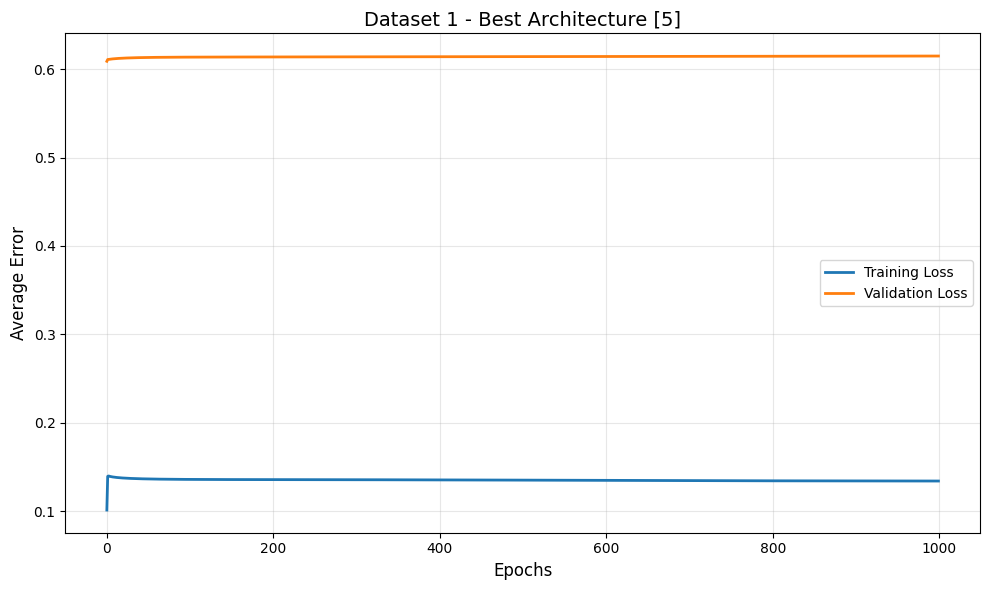

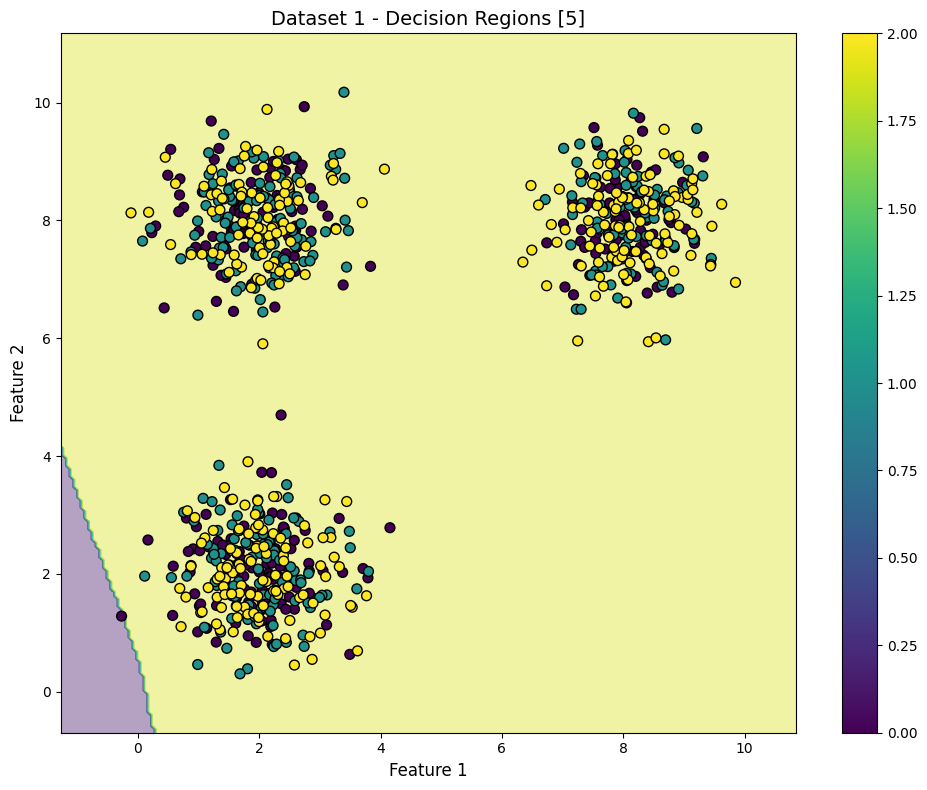

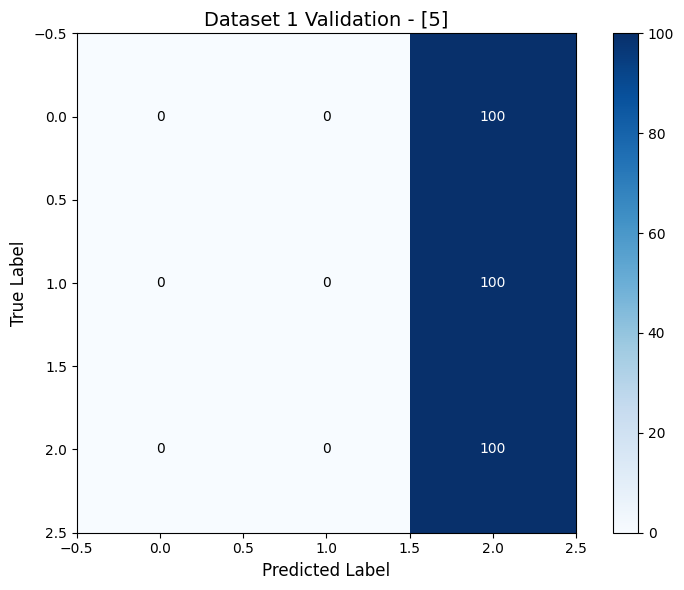

Classification Accuracy: 33.33%


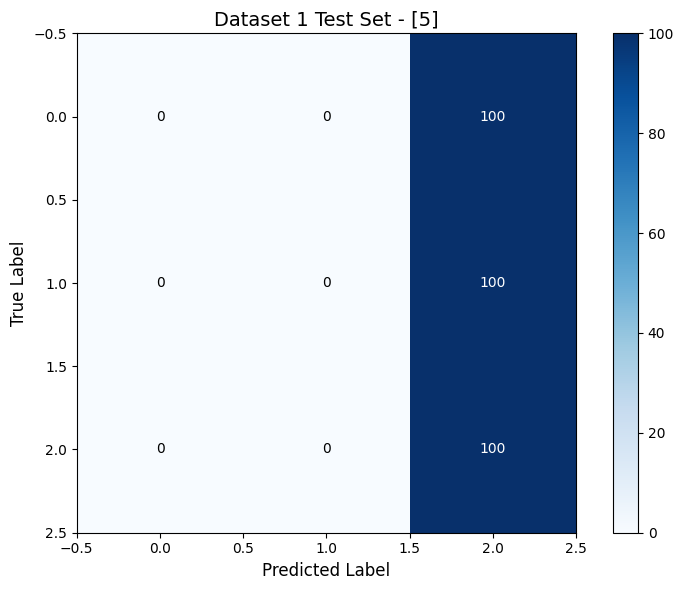

Classification Accuracy: 33.33%


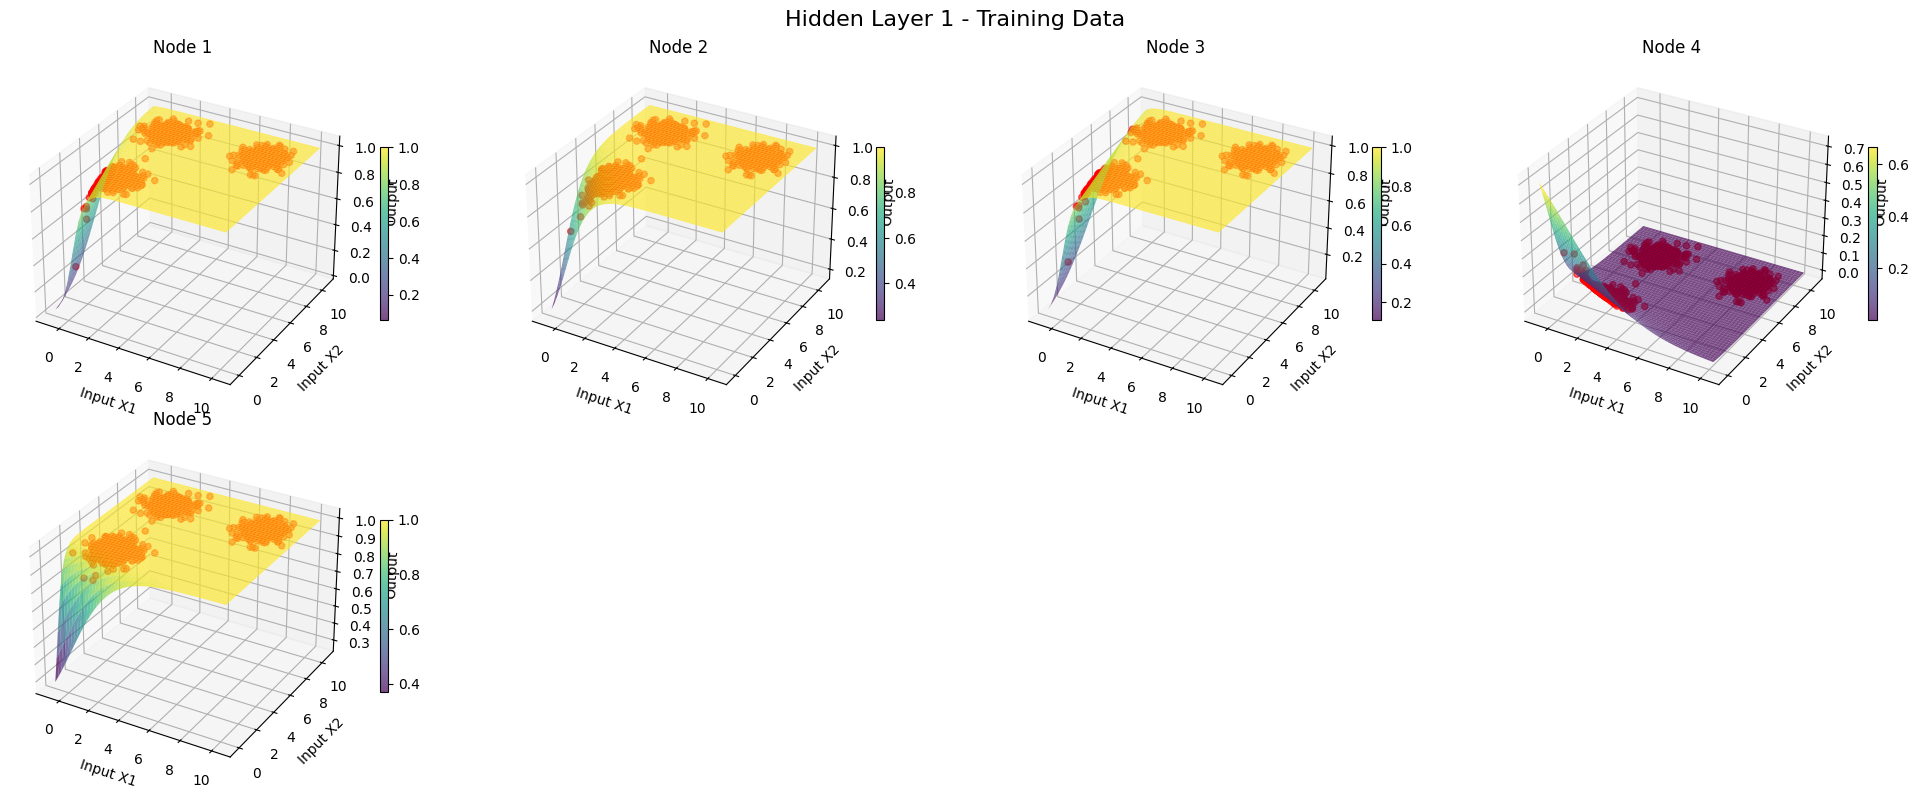

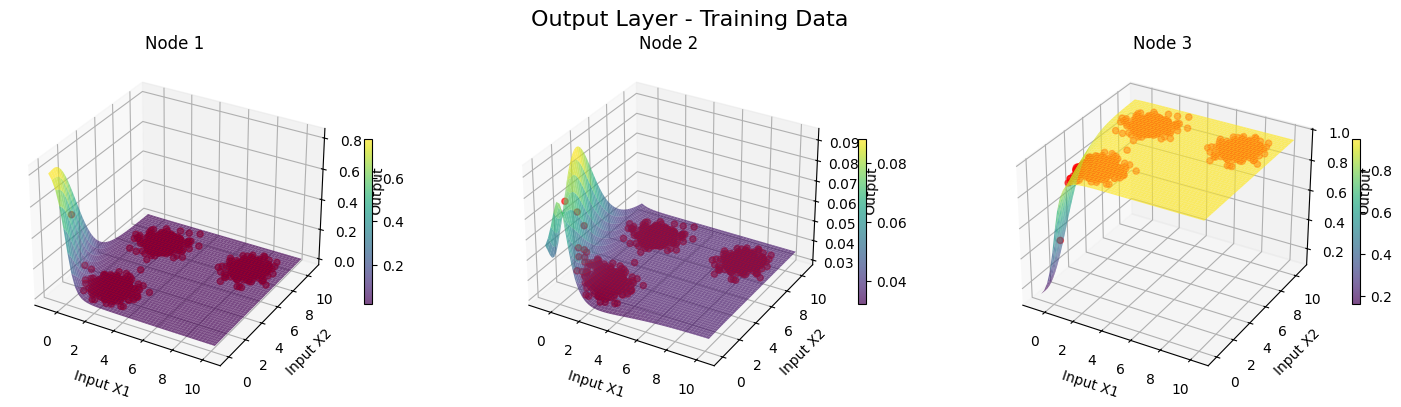

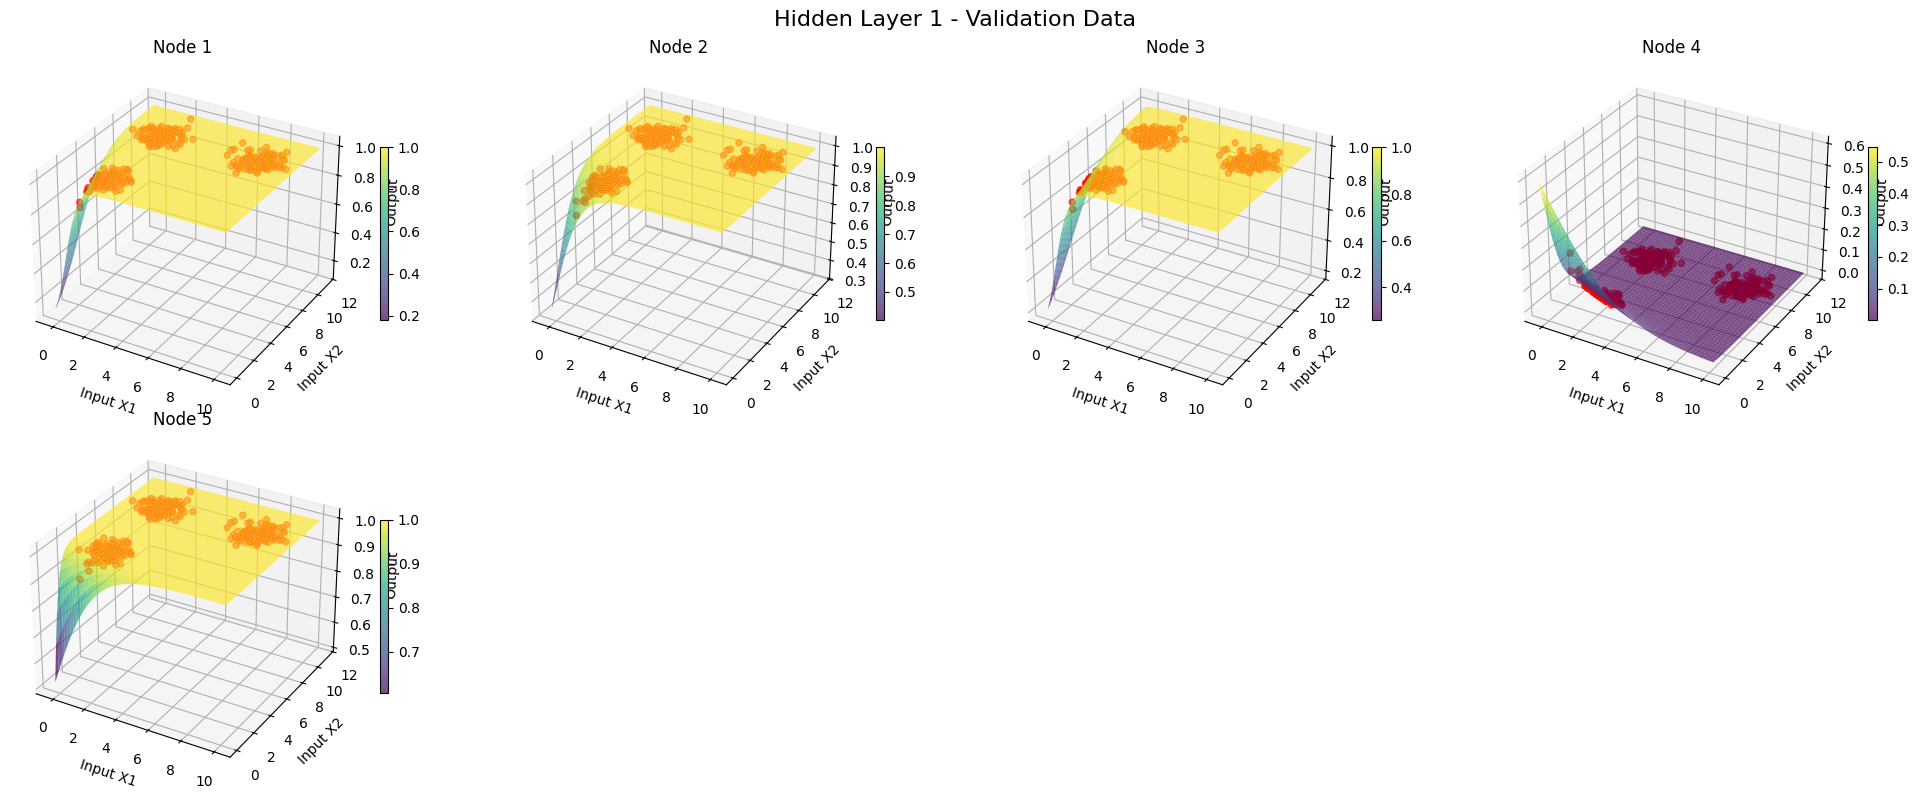

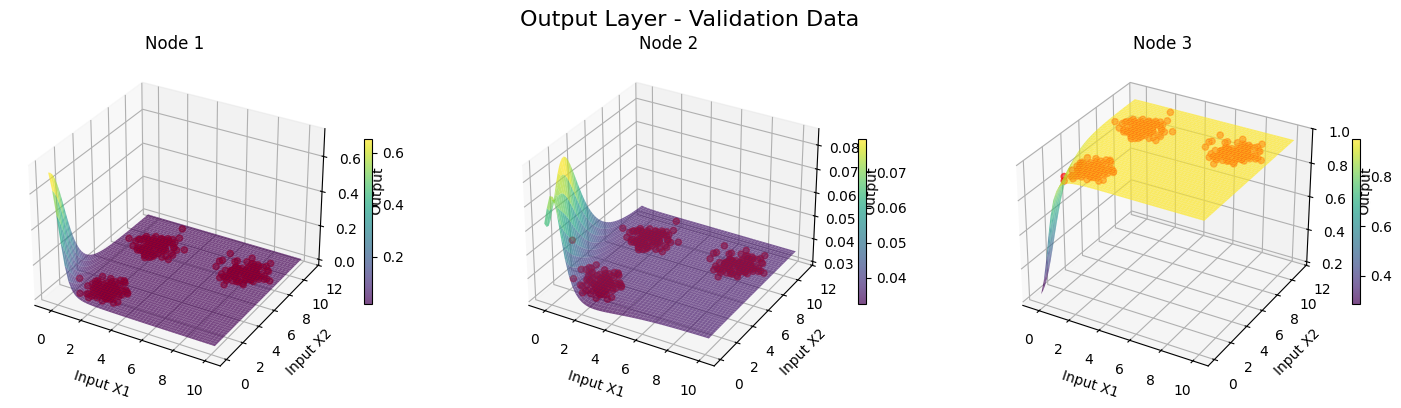

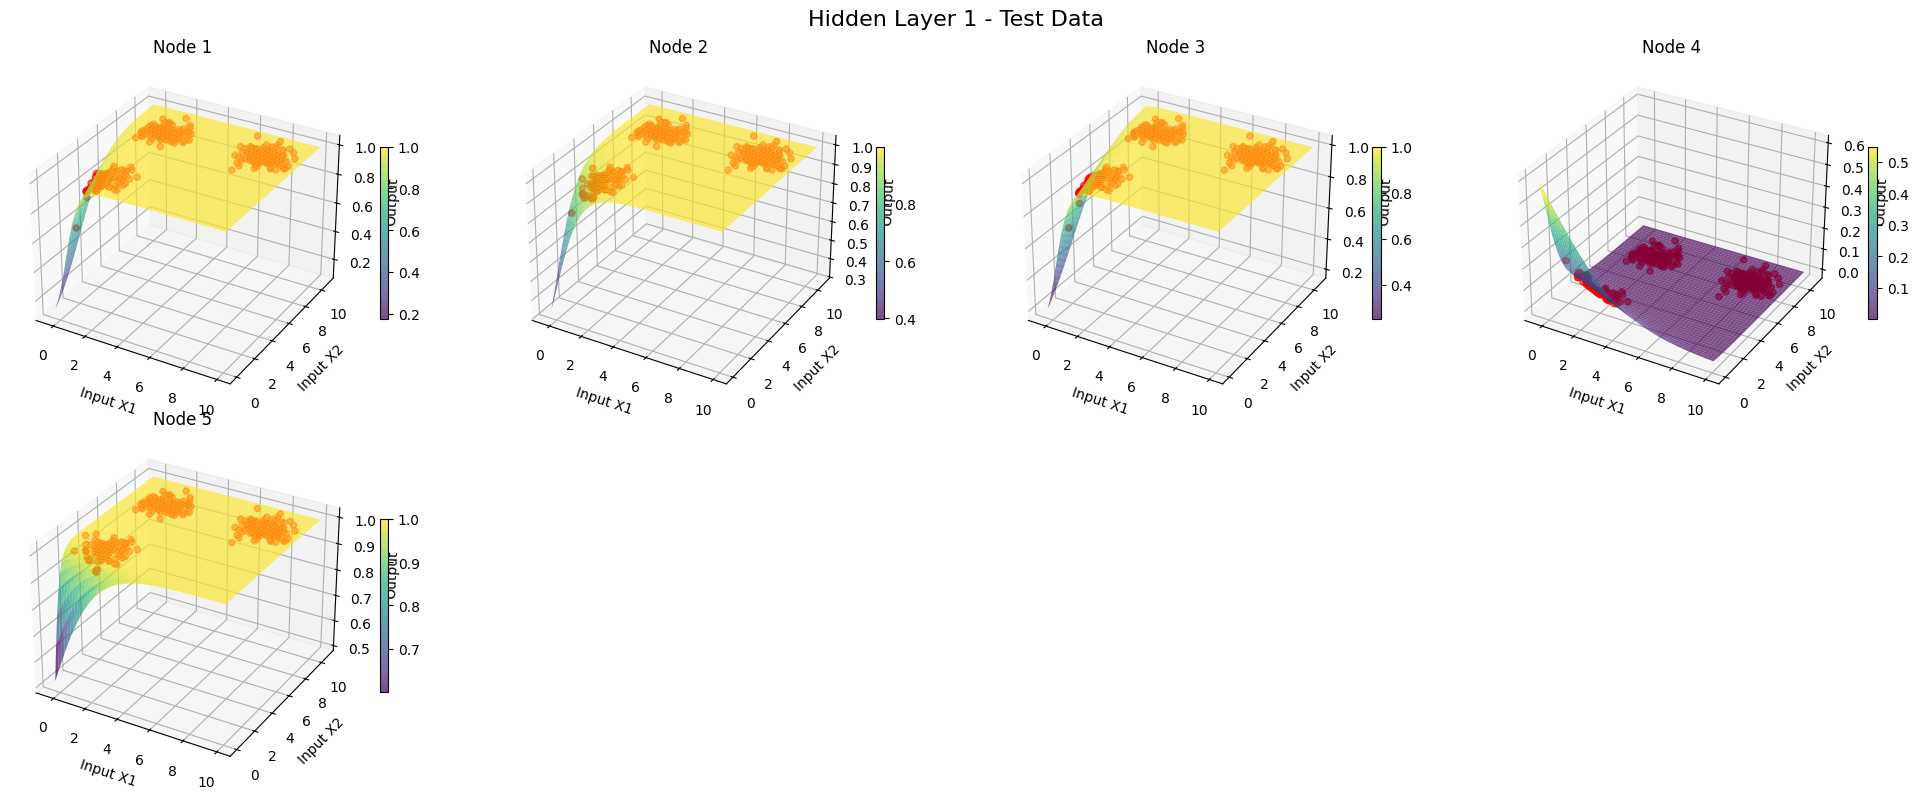

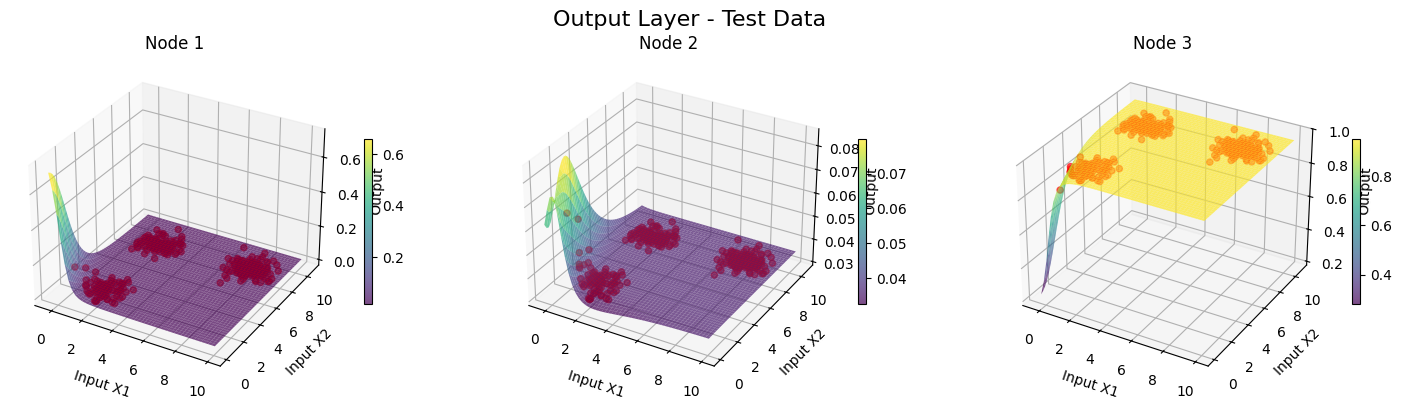


DATASET 2: Nonlinearly Separable

Testing architecture: [10, 5]
Epoch 100/1500, Train Loss: 0.0285, Val Loss: 0.1105
Epoch 200/1500, Train Loss: 0.0069, Val Loss: 0.0188
Epoch 300/1500, Train Loss: 0.0056, Val Loss: 0.0108
Epoch 400/1500, Train Loss: 0.0052, Val Loss: 0.0090
Epoch 500/1500, Train Loss: 0.0048, Val Loss: 0.0092
Epoch 600/1500, Train Loss: 0.0045, Val Loss: 0.0101
Epoch 700/1500, Train Loss: 0.0043, Val Loss: 0.0110
Epoch 800/1500, Train Loss: 0.0042, Val Loss: 0.0120
Epoch 900/1500, Train Loss: 0.0042, Val Loss: 0.0128
Epoch 1000/1500, Train Loss: 0.0041, Val Loss: 0.0135
Epoch 1100/1500, Train Loss: 0.0040, Val Loss: 0.0140
Epoch 1200/1500, Train Loss: 0.0039, Val Loss: 0.0143
Epoch 1300/1500, Train Loss: 0.0038, Val Loss: 0.0145
Epoch 1400/1500, Train Loss: 0.0036, Val Loss: 0.0146
Epoch 1500/1500, Train Loss: 0.0035, Val Loss: 0.0146
Validation Accuracy: 98.00%
Confusion Matrix:
[[97  3]
 [ 1 99]]

Testing architecture: [15, 10]
Epoch 100/1500, Train Loss: 0.0323, V

In [ ]:
# For Dataset 1 (Linearly Separable - 3 classes)
print("="*60)
print("DATASET 1: Linearly Separable (3 classes)")
print("="*60)

# Load data
X_train1, y_train1, X_val1, y_val1, X_test1, y_test1 = load_and_split_data('dataset1.txt')

# Try different single-hidden-layer architectures
hidden_configs1 = [[5], [10], [15], [20]]

results1, best1 = cross_validate_architectures(X_train1, y_train1, X_val1, y_val1,
                                               hidden_configs1, epochs=1000)

# Visualize best model
print("\nVisualizations for Best Architecture:")
plot_loss_curve(best1['train_losses'], best1['val_losses'],
               title=f"Dataset 1 - Best Architecture {best1['hidden_dims']}")

plot_decision_boundary(best1['model'], X_train1, y_train1,
                      title=f"Dataset 1 - Decision Regions {best1['hidden_dims']}")

plot_confusion_matrix(best1['confusion_matrix'],
                     title=f"Dataset 1 Validation - {best1['hidden_dims']}")

# Test set evaluation
test_cm1 = compute_confusion_matrix(best1['model'], X_test1, y_test1)
plot_confusion_matrix(test_cm1, title=f"Dataset 1 Test Set - {best1['hidden_dims']}")

# 3D plots of node outputs
plot_node_outputs_3d(best1['model'], X_train1, y_train1, "Training")
plot_node_outputs_3d(best1['model'], X_val1, y_val1, "Validation")
plot_node_outputs_3d(best1['model'], X_test1, y_test1, "Test")

# For Dataset 2 (Nonlinearly Separable)
print("\n" + "="*60)
print("DATASET 2: Nonlinearly Separable")
print("="*60)

X_train2, y_train2, X_val2, y_val2, X_test2, y_test2 = load_and_split_data('dataset2.txt')

# Try different two-hidden-layer architectures
hidden_configs2 = [[10, 5], [15, 10], [20, 10], [15, 8]]

results2, best2 = cross_validate_architectures(X_train2, y_train2, X_val2, y_val2,
                                               hidden_configs2, epochs=1500)
print("\nVisualizations for Best Architecture:")
plot_loss_curve(best2['train_losses'], best2['val_losses'],
               title=f"Dataset 1 - Best Architecture {best2['hidden_dims']}")

plot_decision_boundary(best2['model'], X_train2, y_train2,
                      title=f"Dataset 1 - Decision Regions {best2['hidden_dims']}")

plot_confusion_matrix(best2['confusion_matrix'],
                     title=f"Dataset 1 Validation - {best2['hidden_dims']}")

# Test set evaluation
test_cm1 = compute_confusion_matrix(best2['model'], X_test2, y_test2)
plot_confusion_matrix(test_cm1, title=f"Dataset 1 Test Set - {best2['hidden_dims']}")

# 3D plots of node outputs
plot_node_outputs_3d(best1['model'], X_train2, y_train2, "Training")
plot_node_outputs_3d(best1['model'], X_val2, y_val2, "Validation")
plot_node_outputs_3d(best1['model'], X_test2, y_test2, "Test")

# Same visualizations for Dataset 2...



Visualizations for Best Architecture:


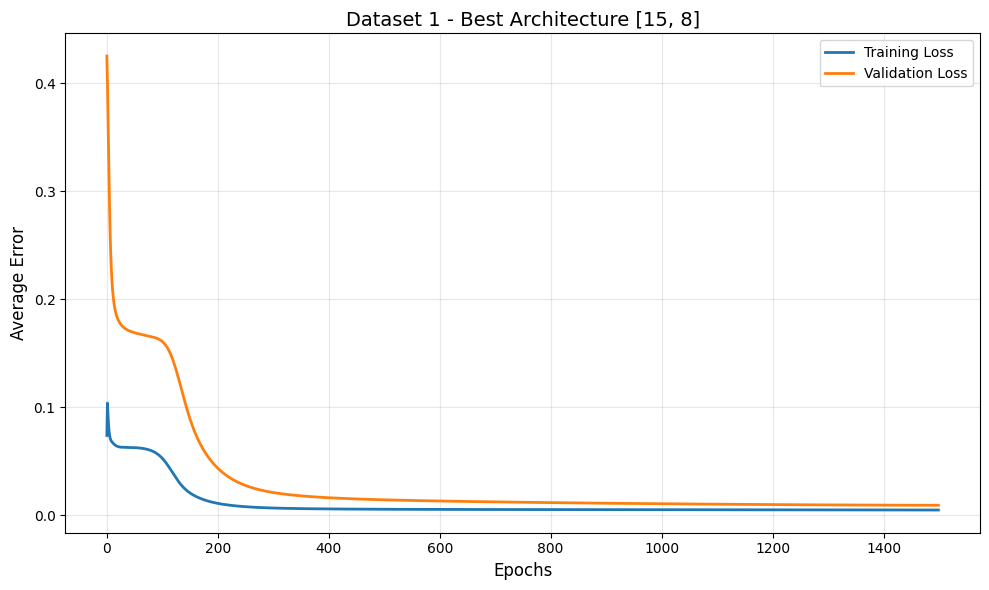

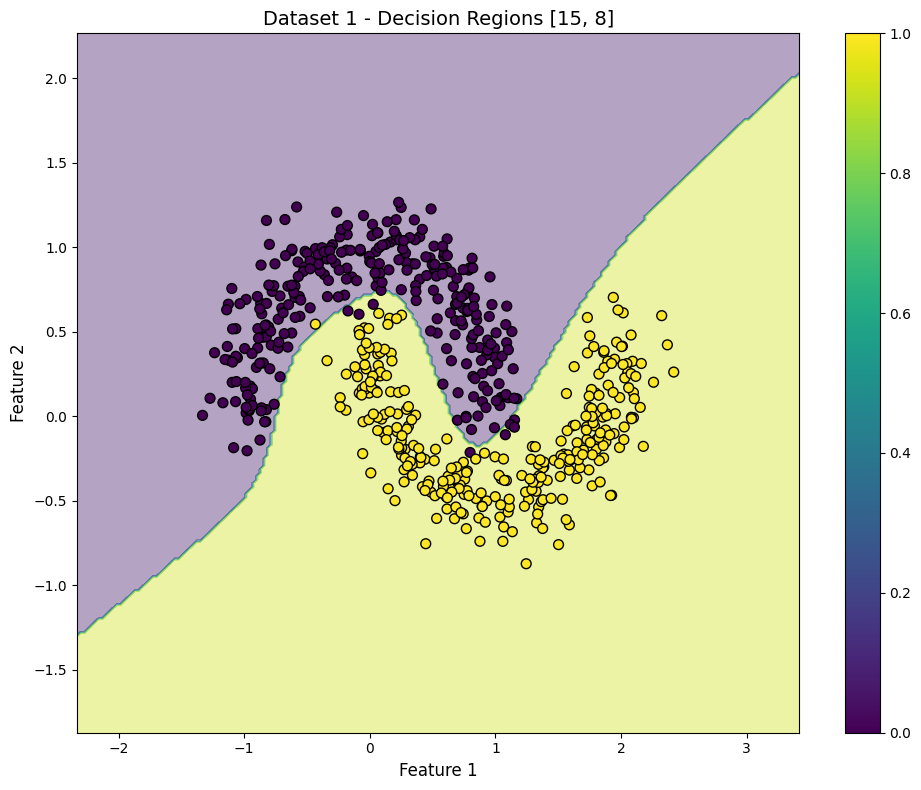

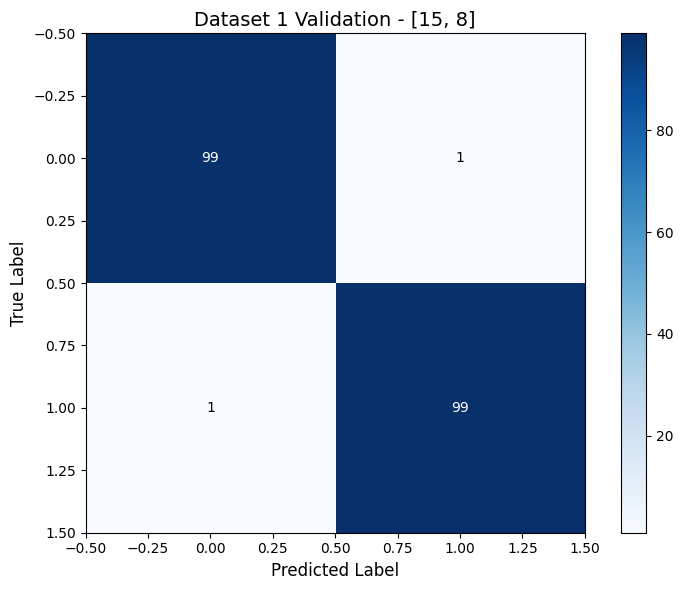

Classification Accuracy: 99.00%


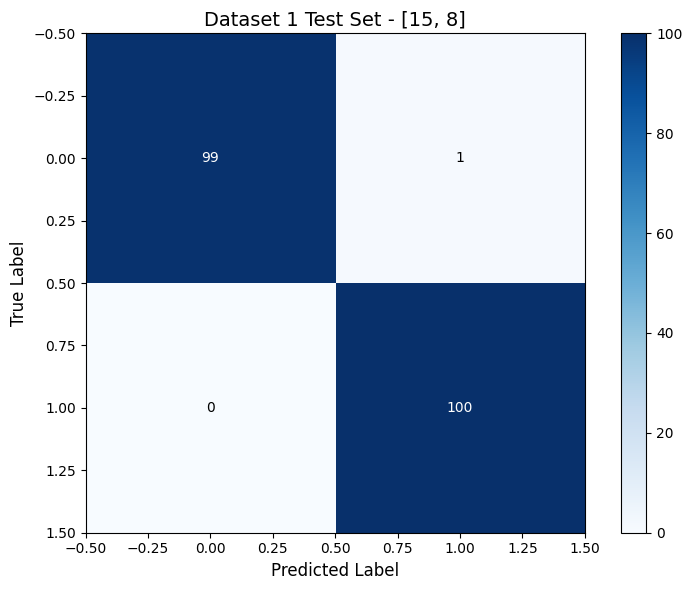

Classification Accuracy: 99.50%


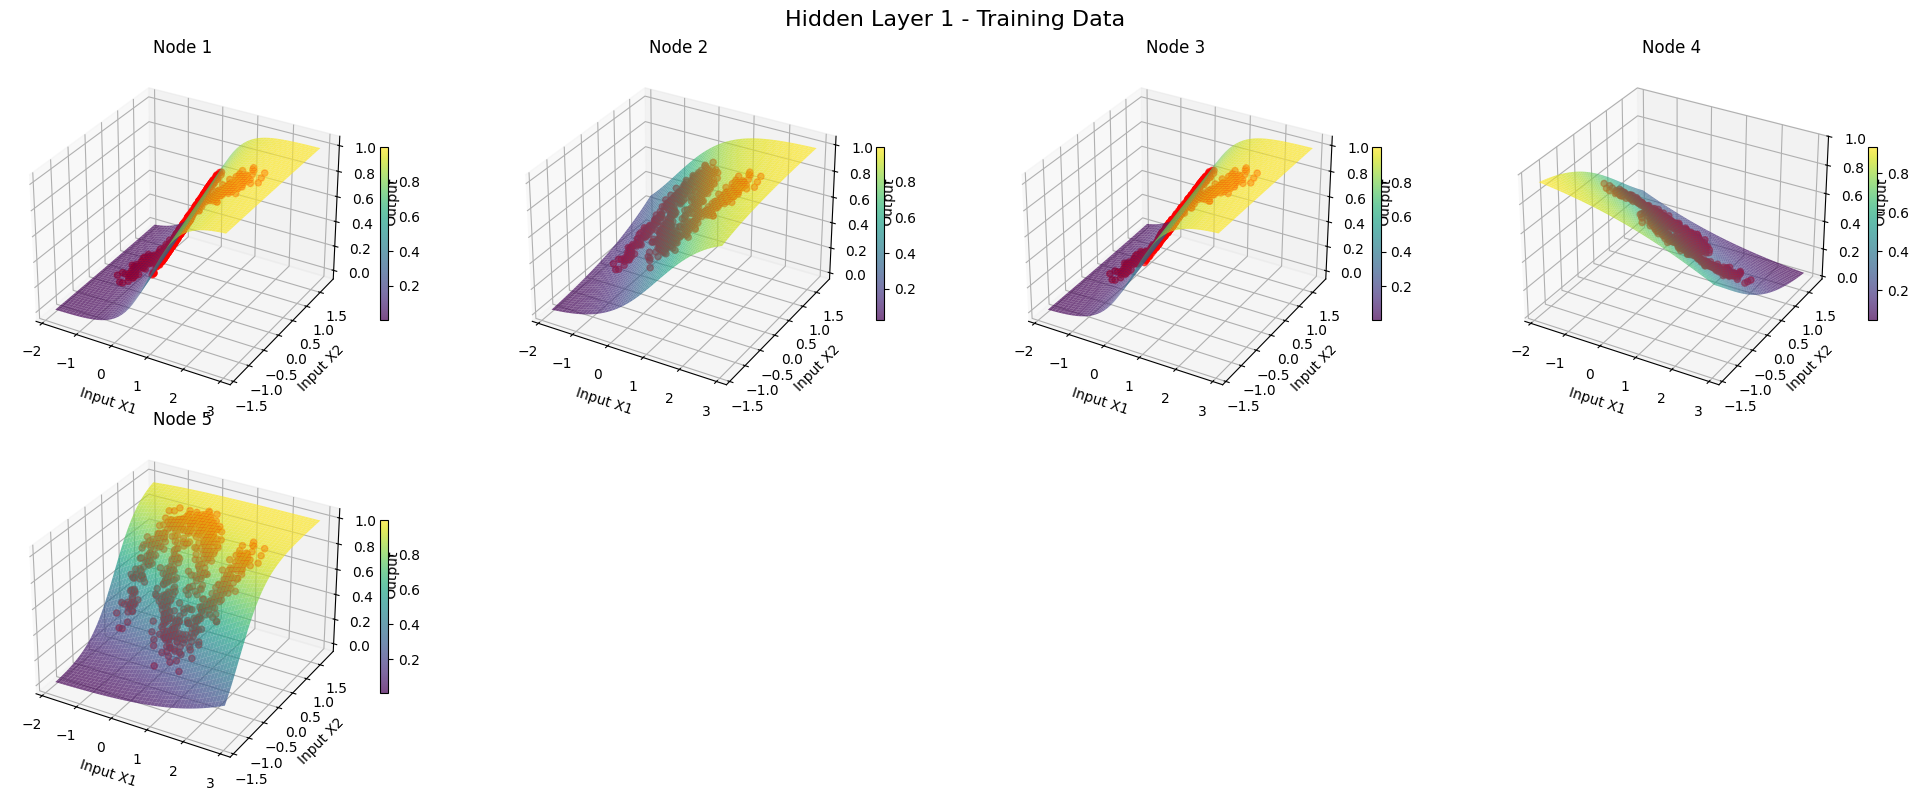

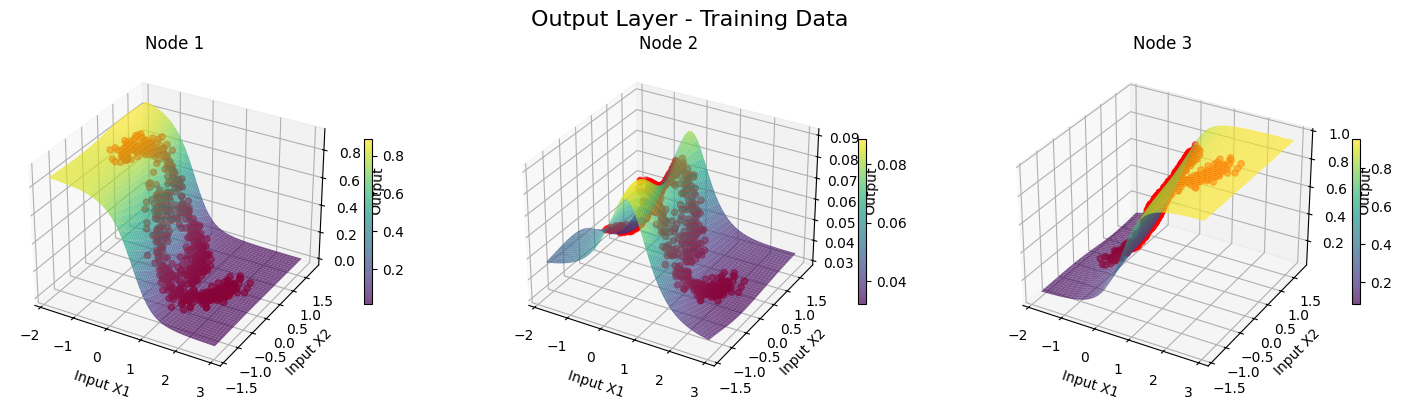

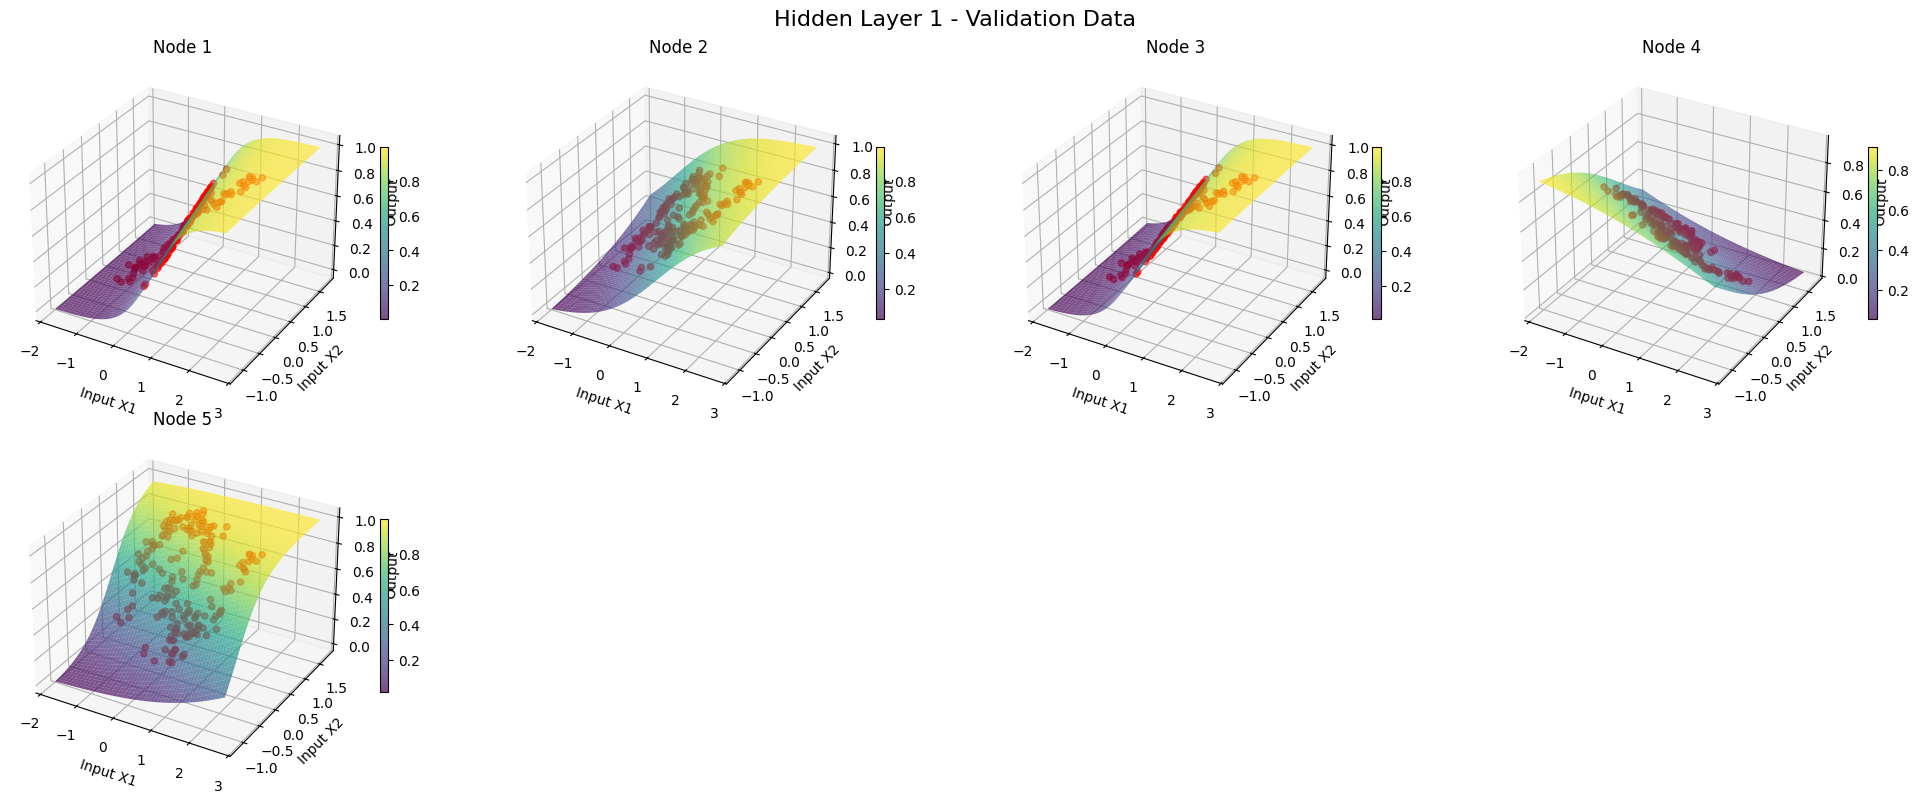

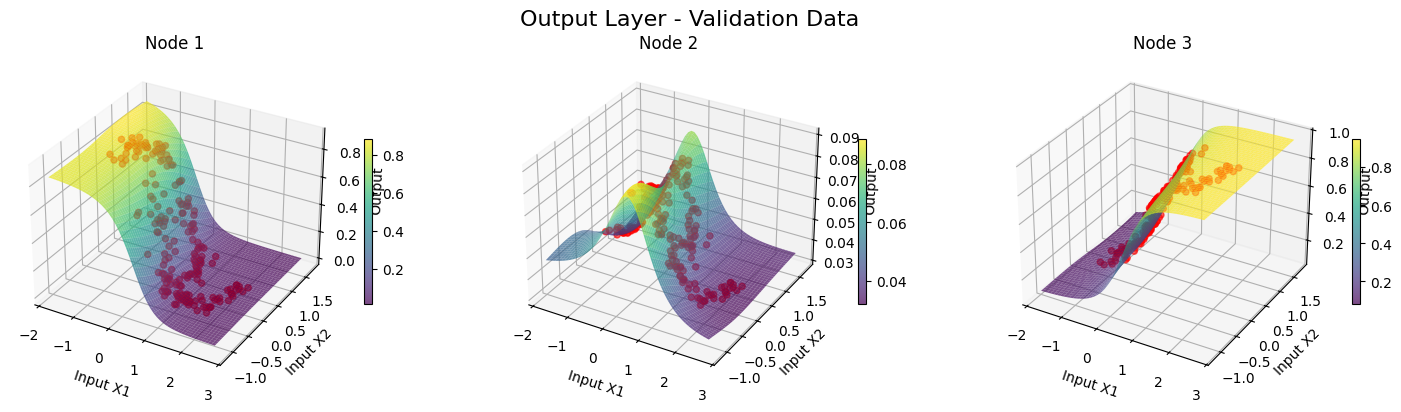

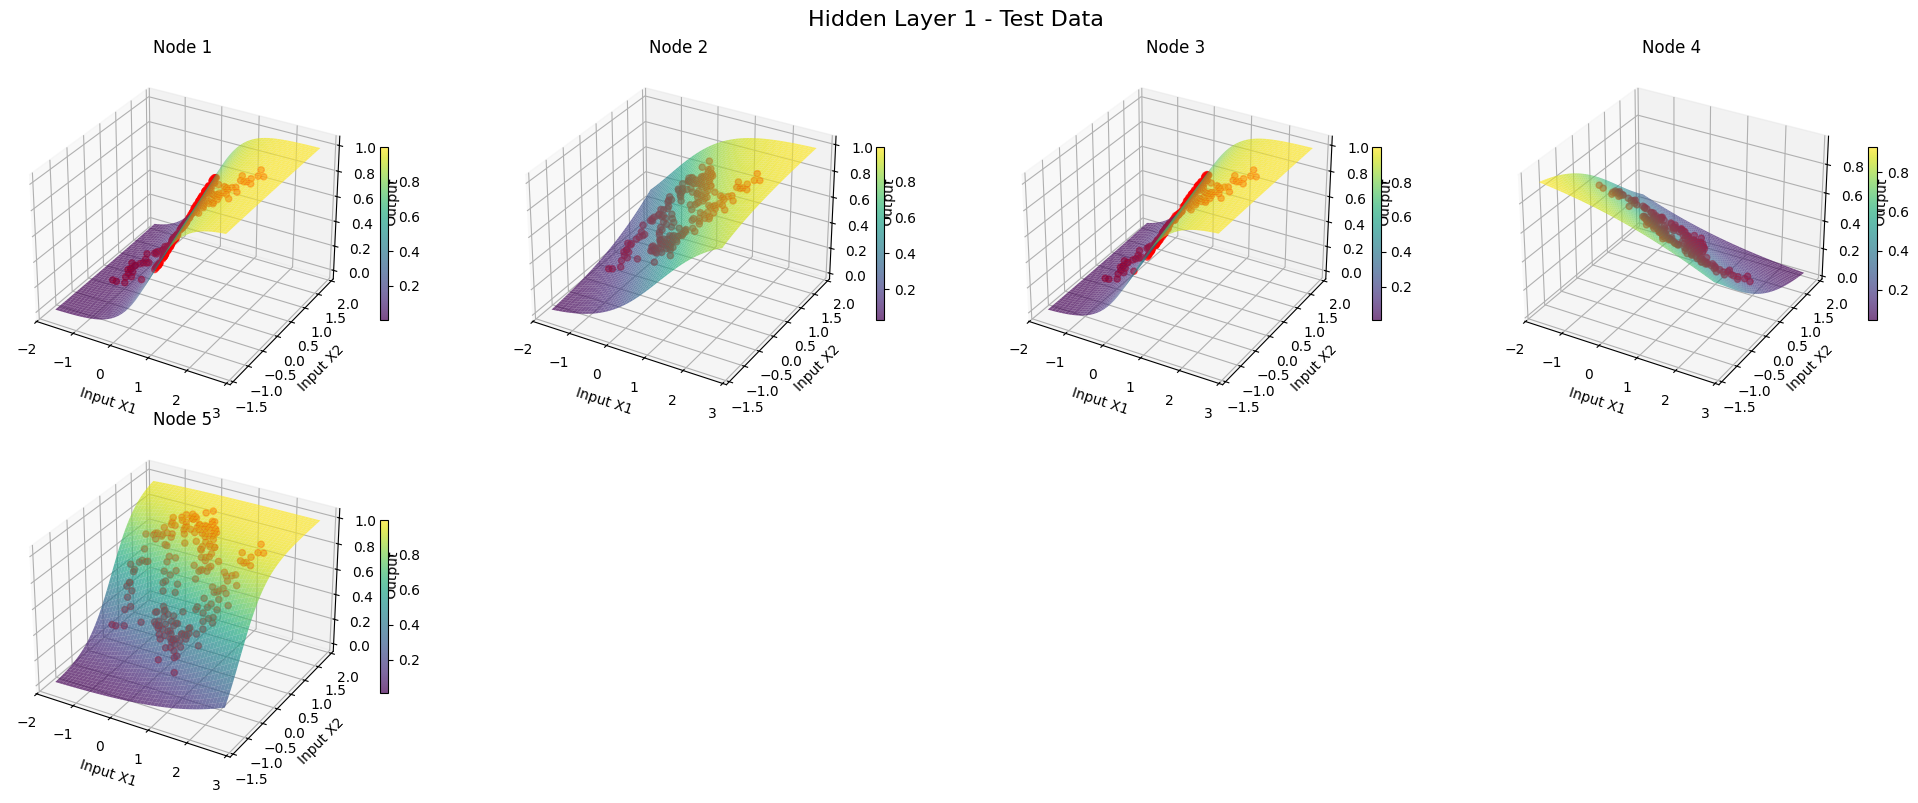

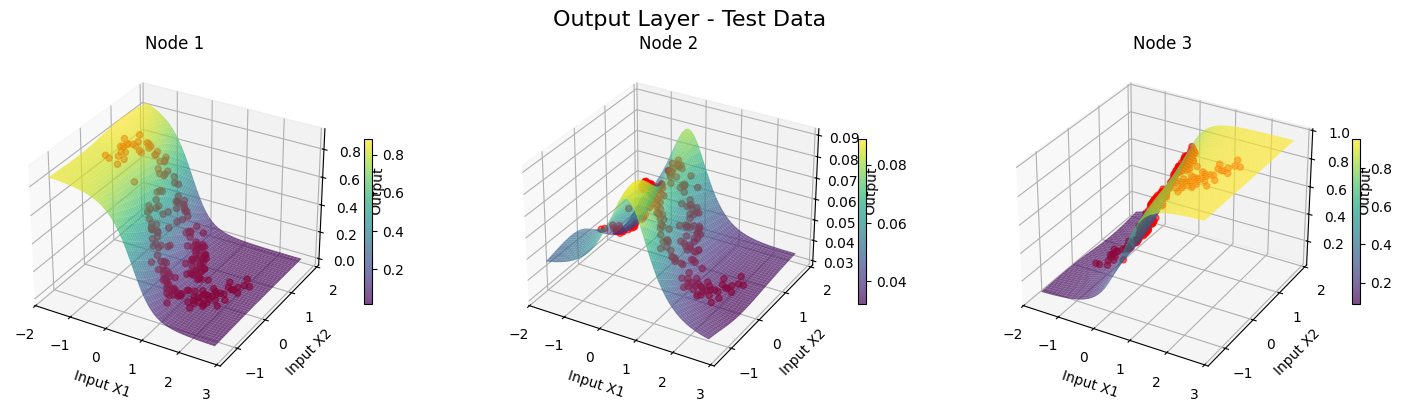

In [ ]:
print("\nVisualizations for Best Architecture:")
plot_loss_curve(best2['train_losses'], best2['val_losses'],
               title=f"Dataset 1 - Best Architecture {best2['hidden_dims']}")

plot_decision_boundary(best2['model'], X_train2, y_train2,
                      title=f"Dataset 1 - Decision Regions {best2['hidden_dims']}")

plot_confusion_matrix(best2['confusion_matrix'],
                     title=f"Dataset 1 Validation - {best2['hidden_dims']}")

# Test set evaluation
test_cm1 = compute_confusion_matrix(best2['model'], X_test2, y_test2)
plot_confusion_matrix(test_cm1, title=f"Dataset 1 Test Set - {best2['hidden_dims']}")

# 3D plots of node outputs
plot_node_outputs_3d(best1['model'], X_train2, y_train2, "Training")
plot_node_outputs_3d(best1['model'], X_val2, y_val2, "Validation")
plot_node_outputs_3d(best1['model'], X_test2, y_test2, "Test")